In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [9]:
#### Variables
sns.set_palette('viridis')
formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))
# area = np.pi * 0.5**2
F = 96485 # C/mol
thickness = 80e-7 # cm
#delta_q = F*area*L(Cs-Co)
col = ['Time', 'Time (s)', 'Current (μA)', 'Potential vs Li/Li$^+$ (V)'] # 'Current Density (µA/cm$^2$)'
col2 = ['Potential vs Li/Li$^+$ (V)', 'D (cm$^2$/s)', '$\Delta$Q', 'Cs - Co (mol/cm$^3$)']

#### Model to fit
def PITT(t, delta_q, D, i_b): #t, S, C, D, L ):
    # return ((2 *F * S * C * D)/L) * np.exp(-(np.pi**2 * D * t) / (4 * L ** 2))
    return (2 * delta_q * D / (thickness ** 2)) * np.exp(-((np.pi ** 2) * D * t / (4 * (thickness** 2)))) + i_b
gmodel = Model(PITT)
params = gmodel.make_params() 
params['D'].set(value = 1e-10, min = 1e-20, max = 1e-5)
# params['L'].set(value = 80e-7, vary = False)
params['delta_q'].set(value = 0.1, min = 1e-22)
params['i_b'].set(value = 3e-7, min = 0)

#Data Analysis
def pitt(path, area, thickness, skip, sample):
    data = pd.DataFrame()
    fit_vals = pd.DataFrame(columns = col2)
    files = [os.path.join(path, i) for i in os.listdir(path)]
    n = 0
    for i in files:
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col,  engine = 'python', skipfooter = skip) #4000
        fit = gmodel.fit(df[col[2]], params, t = df[col[1]])
        df['Step'] = i[-8:-4]
        df['Fit'] = fit.best_fit
        data = pd.concat([data, df], ignore_index = True)
        fit_vals.loc[n] = (float(i[-8:-4]), fit.values['D'], fit.values['delta_q'], fit.values['delta_q']/(F * area * thickness))
        n += 1
    data['Sample'] = sample
    fit_vals['Sample'] = sample
    results = [data, fit_vals]
    return results

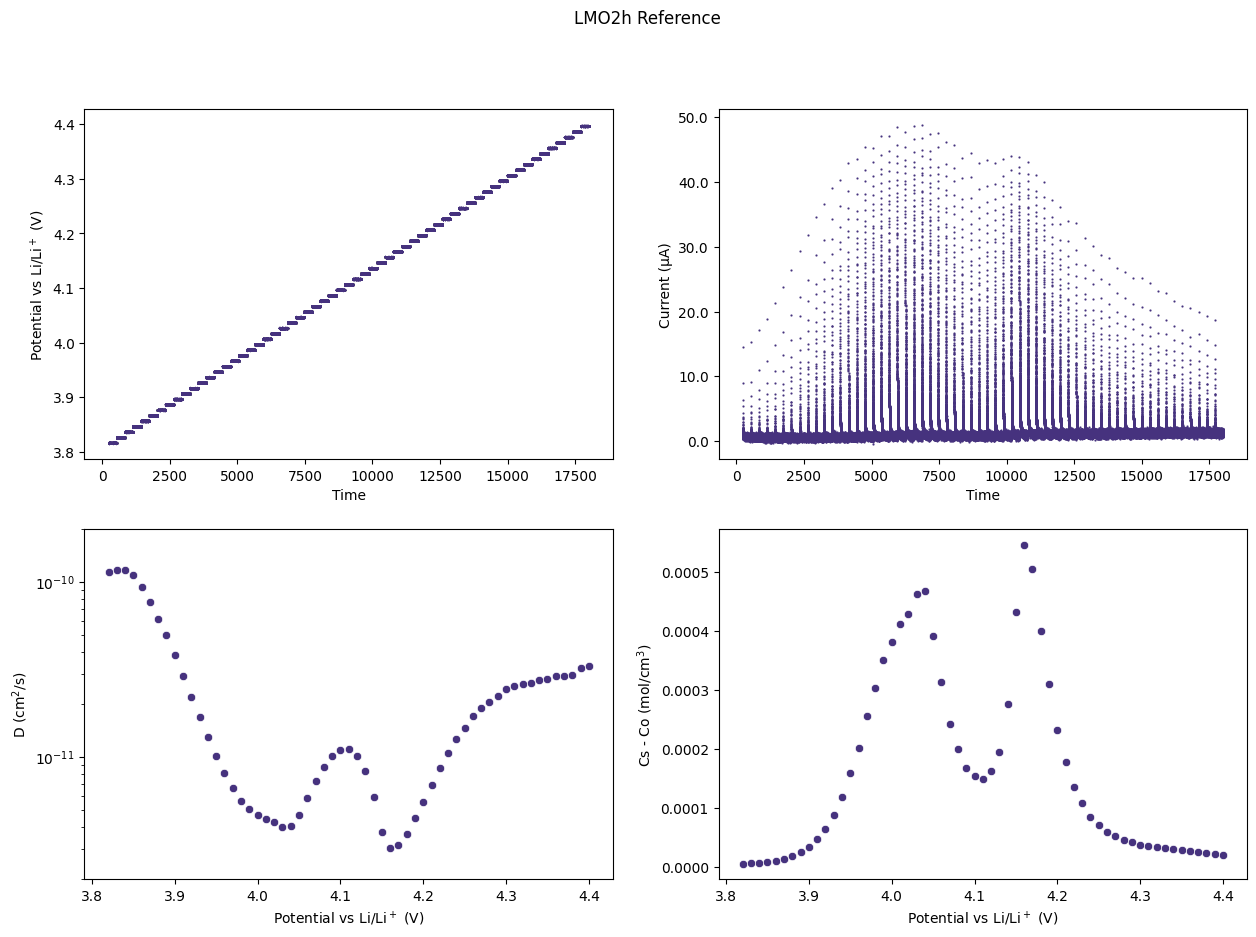

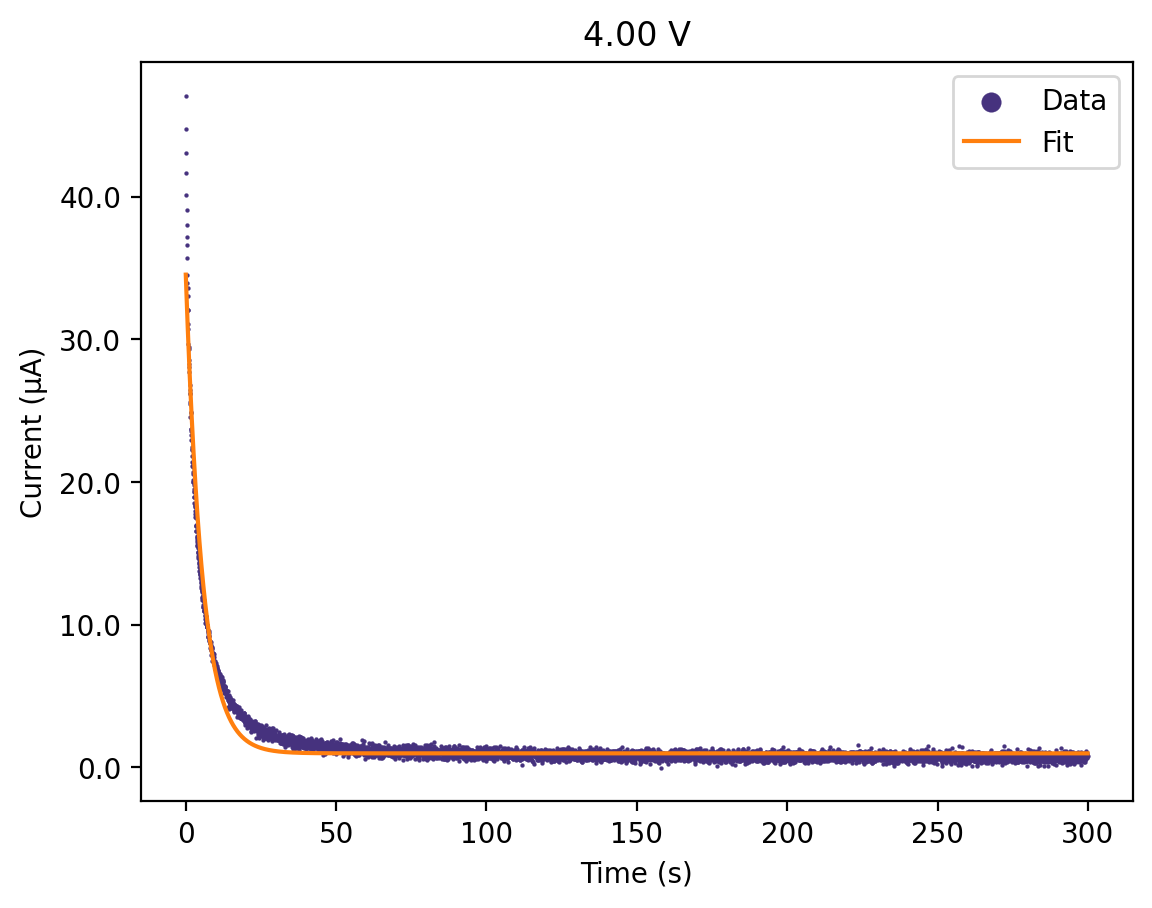

In [10]:
#### LMO 2h PLSA Pt

sample = 'LMO2h Reference'
area = np.pi * 0.5**2 # cm2
thickness = 80e-7 # cm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\PLSA Pt\PITT_10mV'
lmo_pitt = pitt(path, area, thickness, 1, sample)

# Plot
fig, ax = plt.subplots(2,2, dpi =100, figsize = (15,10))
sns.scatterplot(data = lmo_pitt[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
sns.scatterplot(data = lmo_pitt[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
sns.scatterplot(data = lmo_pitt[1], x = col2[0], y = col2[1], ax = ax[1,0])
sns.scatterplot(data = lmo_pitt[1], x = col2[0], y = col2[3])
ax[0,1].yaxis.set_major_formatter(formatter)
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(2e-12, 2e-10)
fig.suptitle(sample)

### Individual steps
### write in step the string of the potential you want to plot
step = '4.00'
u_step = lmo_pitt[0].Step.unique()
df_dict = {i : pd.DataFrame() for i in u_step}
for key in df_dict.keys():
    df_dict[key] = lmo_pitt[0][:][lmo_pitt[0].Step == key]
df = df_dict[step]

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 2, label = 'Data')
sns.lineplot(data = df, x = col[1], y = 'Fit', c = 'tab:orange', label = 'Fit') # edgecolor = None, s = 2
ax.yaxis.set_major_formatter(formatter)
ax.set_title(step + ' V')
ax.legend(markerscale = 5)

Text(0.5, 0.98, 'FL_01')

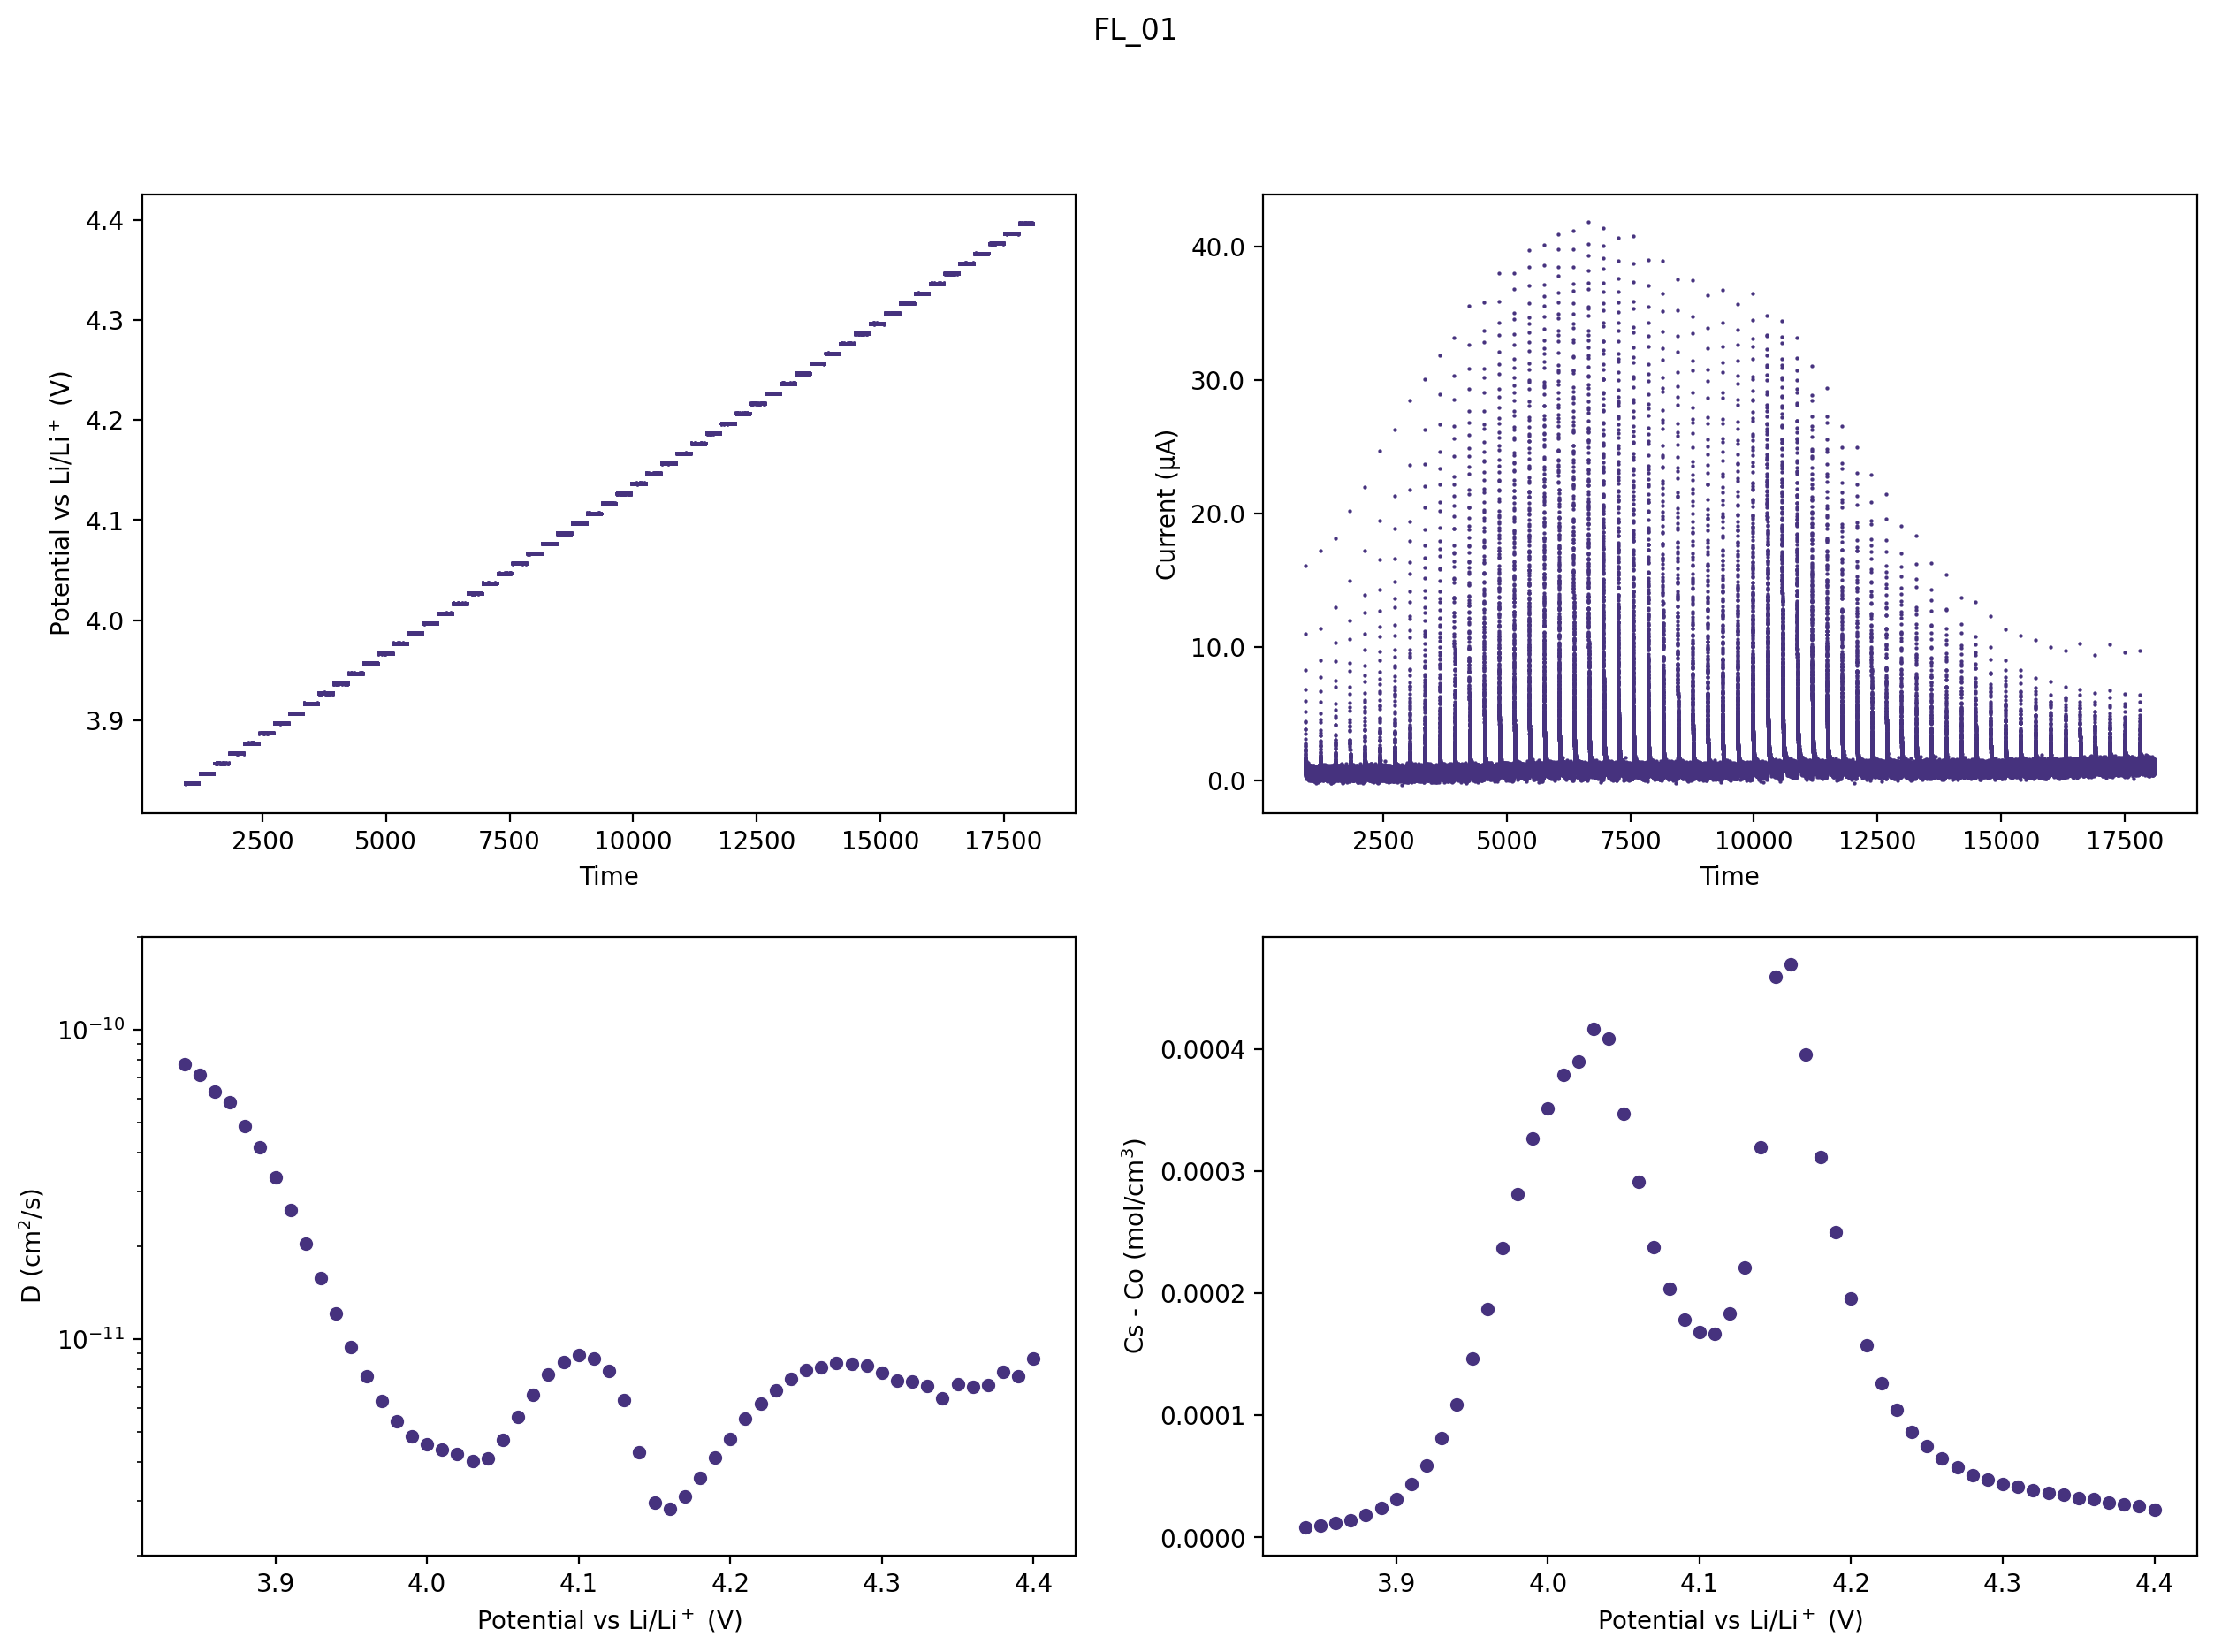

In [11]:
#### NanoSCE mimic solution
sample = 'FL_01'
area = np.pi * 0.5**2 # cm2
thickness = 80e-7 # cm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LESK32\SCE_mimic\Full_Lith_FL\FL_01\PITT2'
fl_01 = pitt(path, area, thickness, 1, sample)

# Plot
fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
sns.scatterplot(data = fl_01[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
sns.scatterplot(data = fl_01[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
sns.scatterplot(data = fl_01[1], x = col2[0], y = col2[1], ax = ax[1,0])
sns.scatterplot(data = fl_01[1], x = col2[0], y = col2[3])
ax[0,1].yaxis.set_major_formatter(formatter)
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(2e-12, 2e-10)
fig.suptitle(sample)

#### Individual steps
#### write in step the string of the potential you want to plot
# step = '4.00'
# u_step = fl_01[0].Step.unique()
# df_dict = {i : pd.DataFrame() for i in u_step}
# for key in df_dict.keys():
#     df_dict[key] = fl_01[0][:][fl_01[0].Step == key]
# df = df_dict[step]

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 2, label = 'Data')
# sns.lineplot(data = df, x = col[1], y = 'Fit', c = 'tab:orange', label = 'Fit') # edgecolor = None, s = 2
# ax.yaxis.set_major_formatter(formatter)
# ax.set_title(step + ' V')
# ax.legend(markerscale = 5)

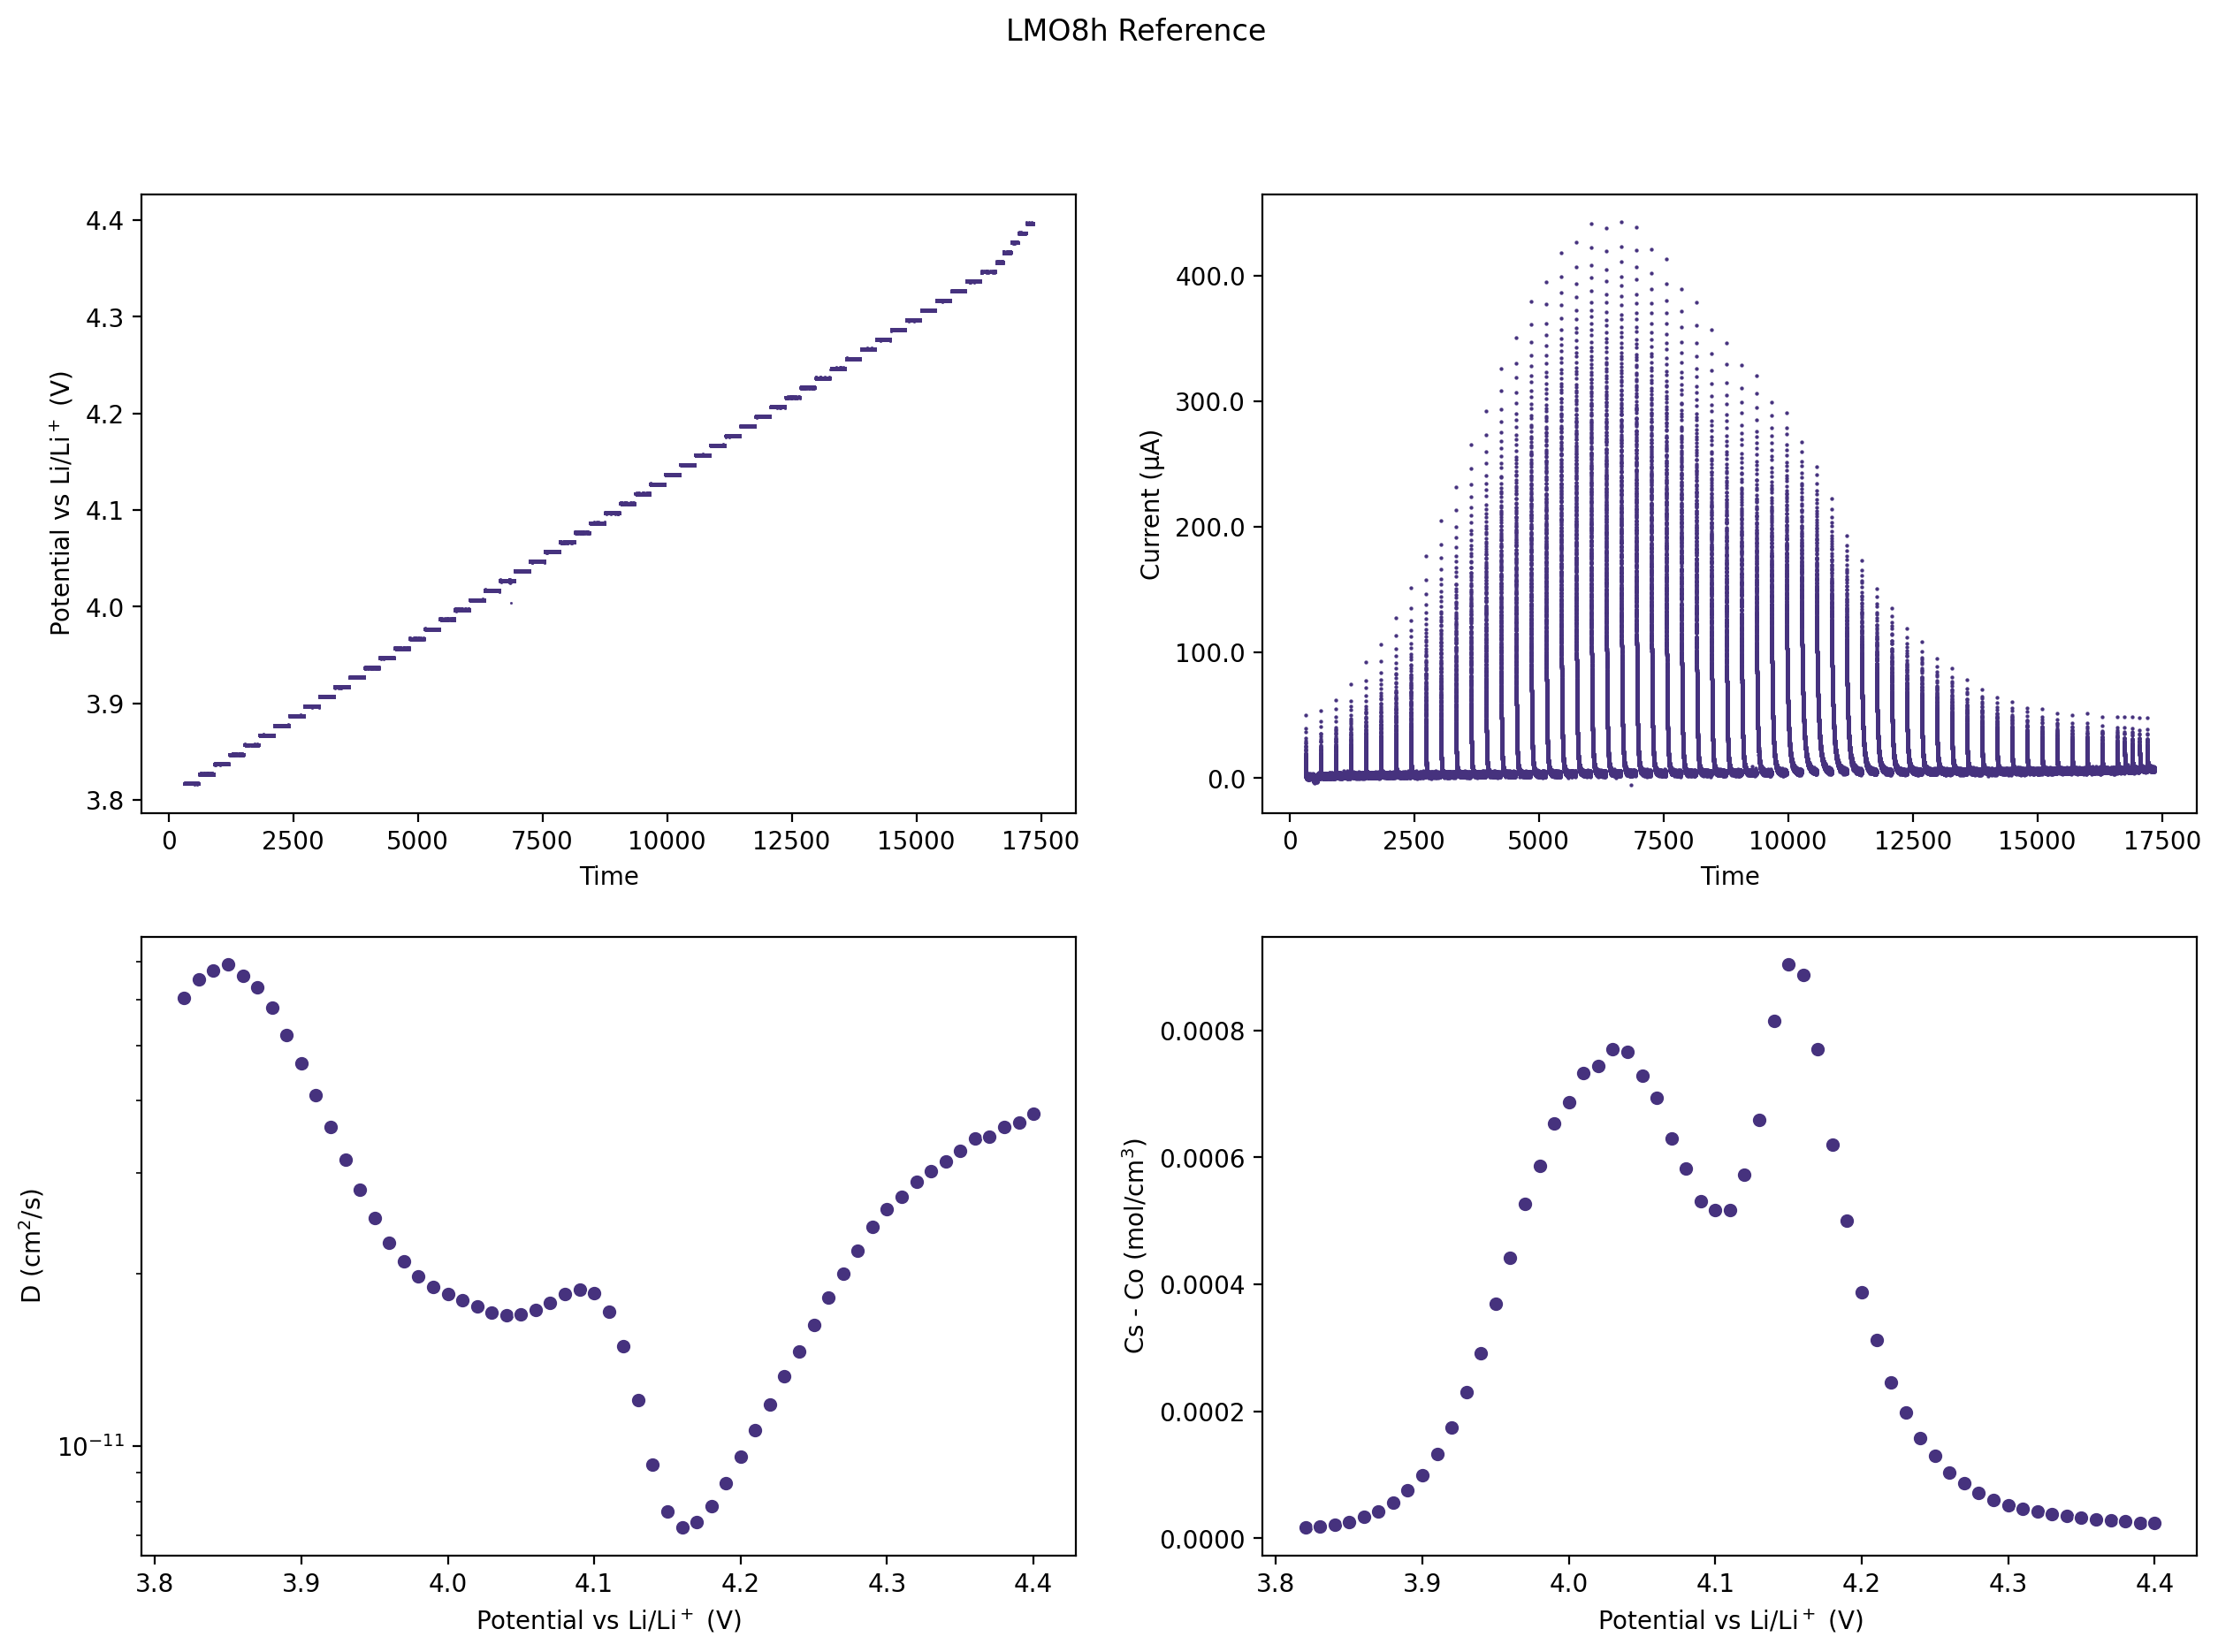

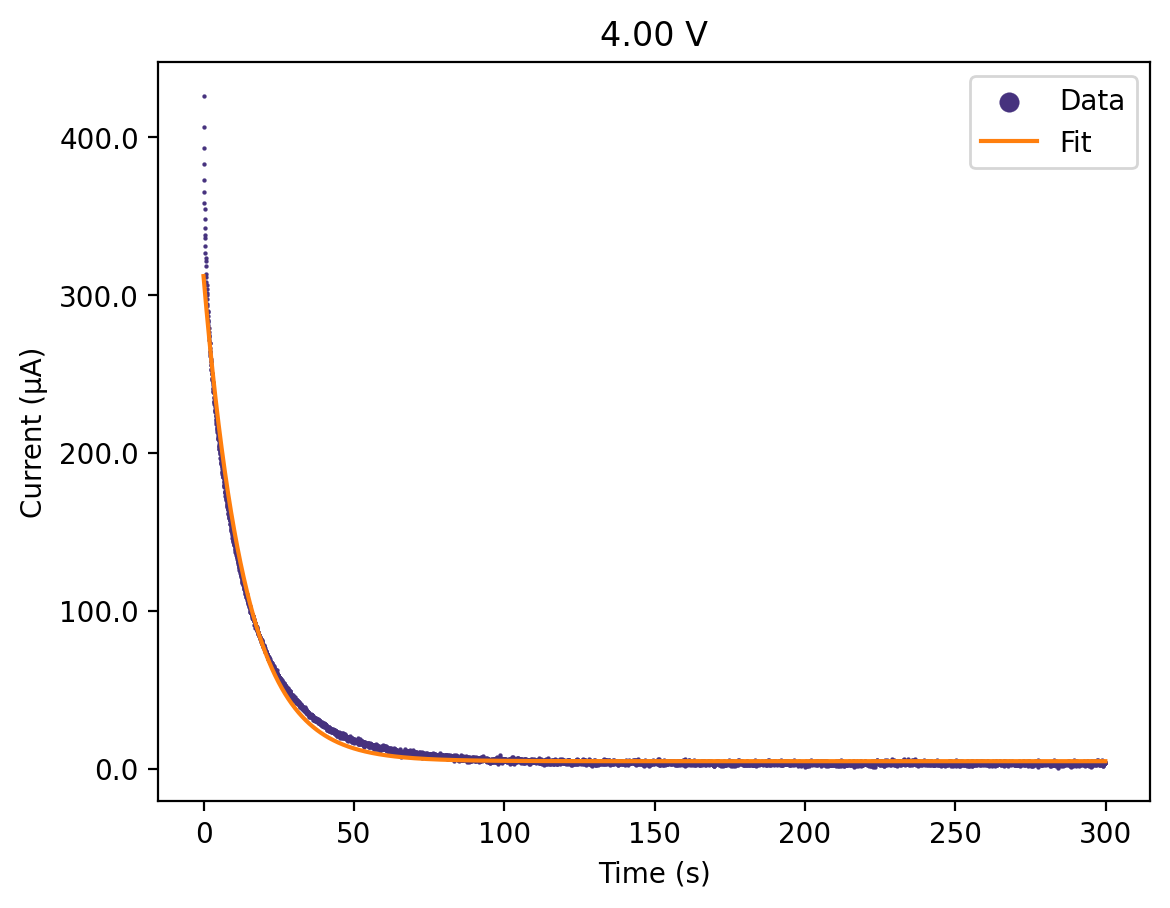

In [12]:
# L81_Ref LMO8h Reference
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L81\L81_Ref2\PITT'
sample = 'LMO8h Reference'
area = np.pi * 1**2 # cm2
thickness = 250e-7 #cm
l81_ref = pitt(path, area, thickness, 1, sample)

fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
sns.scatterplot(data = l81_ref[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
sns.scatterplot(data = l81_ref[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
sns.scatterplot(data = l81_ref[1], x = col2[0], y = col2[1], ax = ax[1,0])
sns.scatterplot(data = l81_ref[1], x = col2[0], y = col2[3])
ax[0,1].yaxis.set_major_formatter(formatter)
ax[1,0].set_yscale('log')
# ax[1,0].set_ylim(2e-12, 2e-10)
fig.suptitle(sample)

#### Individual steps
#### write in step the string of the potential you want to plot
step = '4.00'
u_step = l81_ref[0].Step.unique()
df_dict = {i : pd.DataFrame() for i in u_step}
for key in df_dict.keys():
    df_dict[key] = l81_ref[0][:][l81_ref[0].Step == key]
df = df_dict[step]

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 2, label = 'Data')
sns.lineplot(data = df, x = col[1], y = 'Fit', c = 'tab:orange', label = 'Fit') # edgecolor = None, s = 2
ax.yaxis.set_major_formatter(formatter)
ax.set_title(step + ' V')
ax.legend(markerscale = 5)

Text(0.5, 0.98, 'LMO2h ALD TiO2')

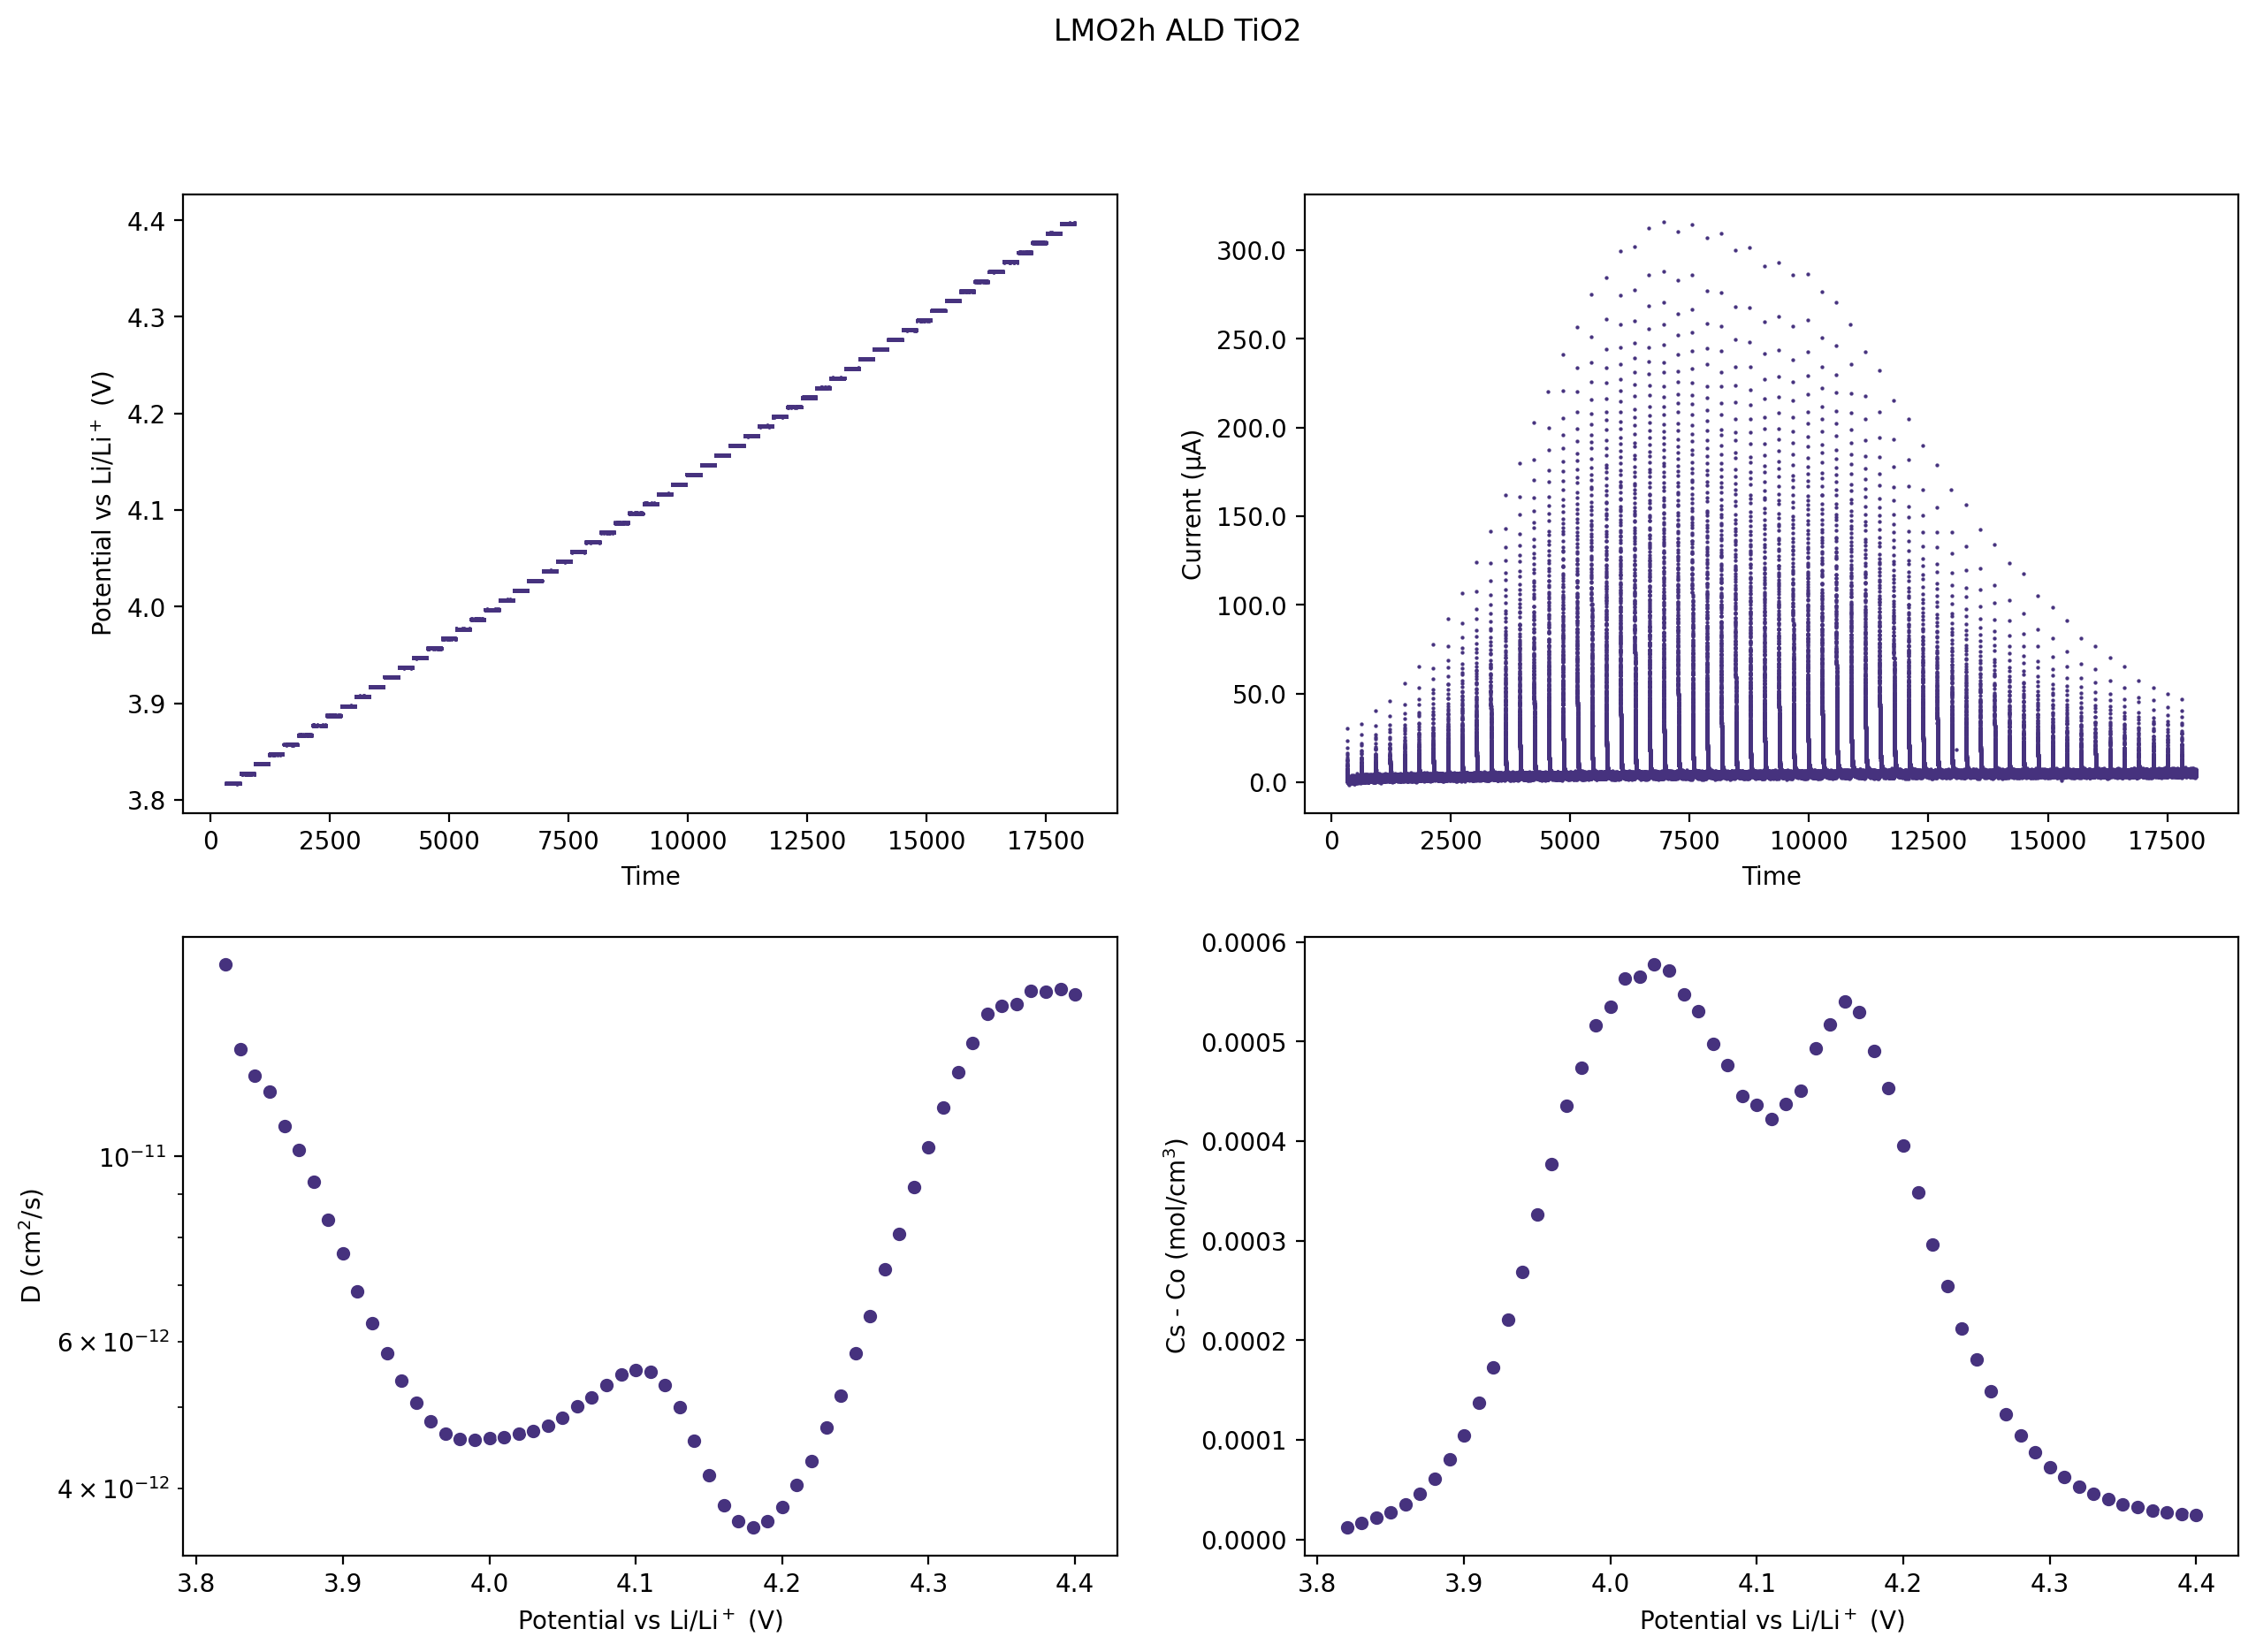

In [13]:
# L20_TiO2_01
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L20\L20_TiO2_01\PITT'
sample = 'LMO2h ALD TiO2'
area = np.pi #cm2
thickness = 80e-7
l20_tio2_01 = pitt(path, area, thickness, 1, sample)

# Plot
fig, ax = plt.subplots(2,2, dpi =200, figsize = (15,10))
sns.scatterplot(data = l20_tio2_01[0], x = col[0], y = col[3], edgecolor = None, ax = ax[0,0], s = 1)
sns.scatterplot(data = l20_tio2_01[0], x = col[0], y = col[2], edgecolor = None, ax = ax[0,1], s = 2)
sns.scatterplot(data = l20_tio2_01[1], x = col2[0], y = col2[1], ax = ax[1,0])
sns.scatterplot(data = l20_tio2_01[1], x = col2[0], y = col2[3])
ax[0,1].yaxis.set_major_formatter(formatter)
ax[1,0].set_yscale('log')
# ax[1,0].set_ylim(2e-12, 2e-11)
fig.suptitle(sample)

# ### Individual steps
# ### write in step the string of the potential you want to plot
# step = '3.85'
# u_step = fl_01[0].Step.unique()
# df_dict = {i : pd.DataFrame() for i in u_step}
# for key in df_dict.keys():
#     df_dict[key] = l20_tio2_01[0][:][l20_tio2_01[0].Step == key]
# df = df_dict[step]

# fig, ax = plt.subplots(dpi = 200)
# sns.scatterplot(data = df, x = col[1], y = col[2], edgecolor = None, s = 2, label = 'Data')
# sns.lineplot(data = df, x = col[1], y = 'Fit', c = 'tab:orange', label = 'Fit') # edgecolor = None, s = 2
# ax.yaxis.set_major_formatter(formatter)
# ax.set_title(step + ' V')
# ax.legend(markerscale = 5)

<AxesSubplot: xlabel='Potential vs Li/Li$^+$ (V)', ylabel='Cs - Co (mol/cm$^3$)'>

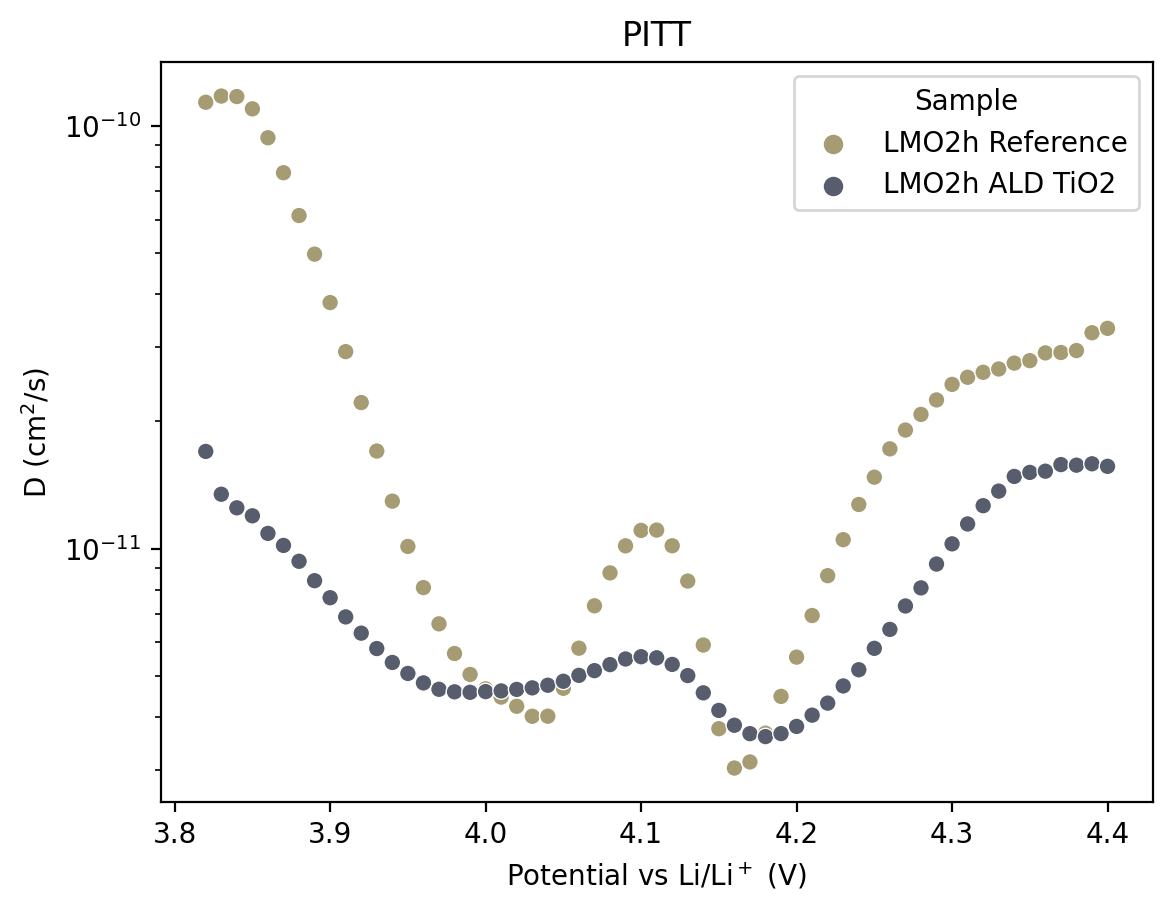

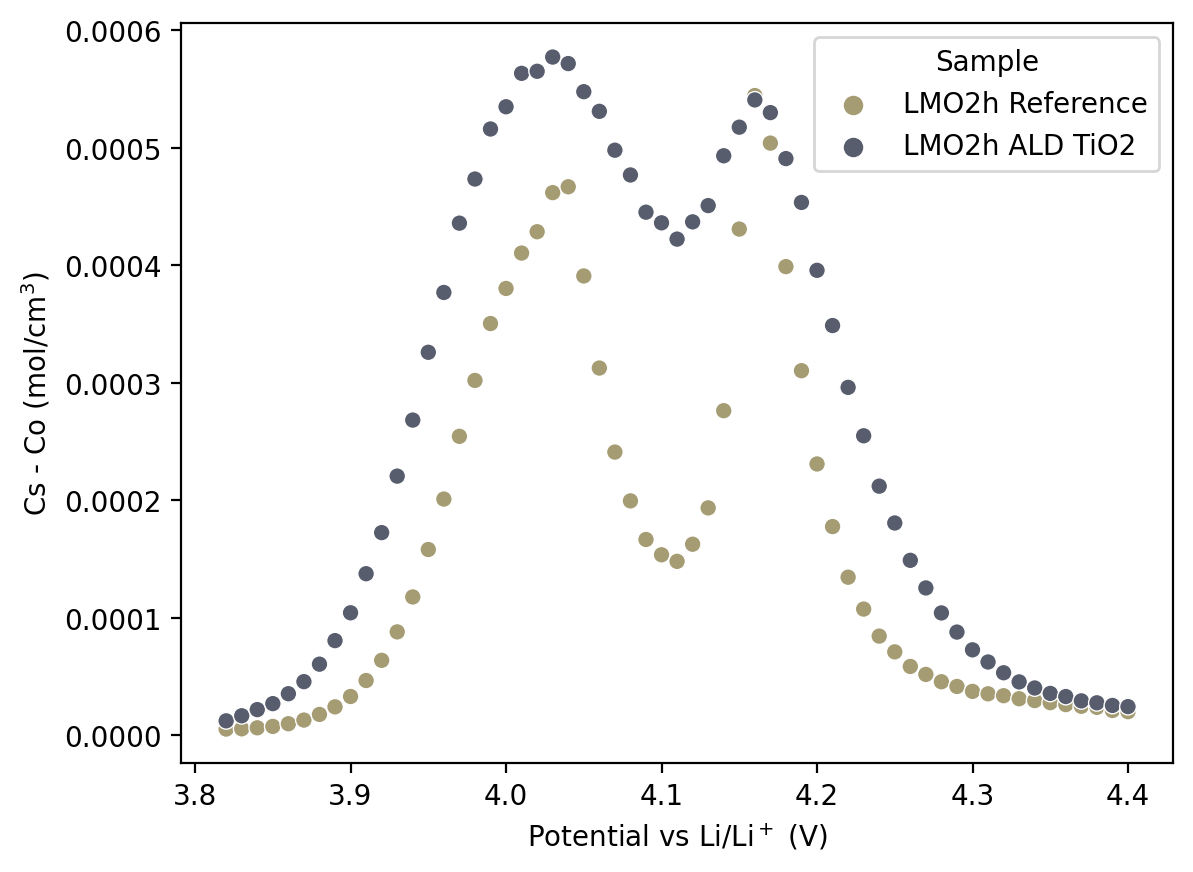

In [14]:
#### Comparison
df = pd.concat([lmo_pitt[1] ,  l20_tio2_01[1]], ignore_index = True) # fl_01[1] l81_ref[1],  l81_ref[1]
# conc = pd.concat(mo_pitt[1] , l81_ref[1]],  ignore_index = True)
fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = df, x = col2[0], y = col2[1], hue = 'Sample', palette = 'cividis_r')
ax.set_yscale('log')
ax.set_title('PITT')

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = df, x = col2[0], y = col2[3], hue = 'Sample', palette = 'cividis_r')